# DSA5101 - Introduction to Big Data for Industry


**Prepared by *Dr Li Xiaoli*** 



# Introduction of Random Forest

In this lecture, we will show how you can use Random Forest algorithm to predict the type of flower species based on the available features, i.e. sepal length, sepal width, petal length and petal width. 

We will show you the analysis in the following steps:
1. Load Data
2. Data exploration and preprocessing
3. Split data into training and testing sets
4. Apply random forest algorithm on the training sets
5. Model evaluation:
  - Training score / Cross-validation score
  - Apply the built model on the testing set to get testing accuracy
  - Get the confusion matrix
  - Get the precision-recall classification report
6. Feature Importance
7. Add noise to the data, let's say 100 noise variables
8. Repeat from step 3. 

### 1. Load Data

1. Load the data
2. Check its data type 
3. Look into the content of the data

In [110]:
### Import packages
import pandas as pd
import numpy as np
import seaborn as sns  # Seaborn is a library for making statistical graphics in Python. 
# It is built on top of matplotlib and closely integrated with pandas data structures.

In [111]:
# Load IRIS dataset from the seaborn packages
iris = sns.load_dataset("iris")

In [112]:
# Check its data type
print ("Data Type:", type(iris))
print ("Dimension:", iris.shape)

Data Type: <class 'pandas.core.frame.DataFrame'>
Dimension: (150, 5)


In [113]:
# Look into the content of the data
print ("\nFirst 5 rows:\n", iris.head(5))


First 5 rows:
    sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


### 2. Data Exploration and Preprocessing

**Pairplot**

There are 5 columns altogether in the dataset. Let's have a quick pairplot to have a look on how the data looks like. It is quite clear that Setosa species is quite distinct from the other two species. However, there is some overlap between Versicolor and Virginica. 
From the correlation plot, it is clear for plots in 3rd/4-th column/row, setosa is small in terms of petal and sepal (petal_length and petal_width) 



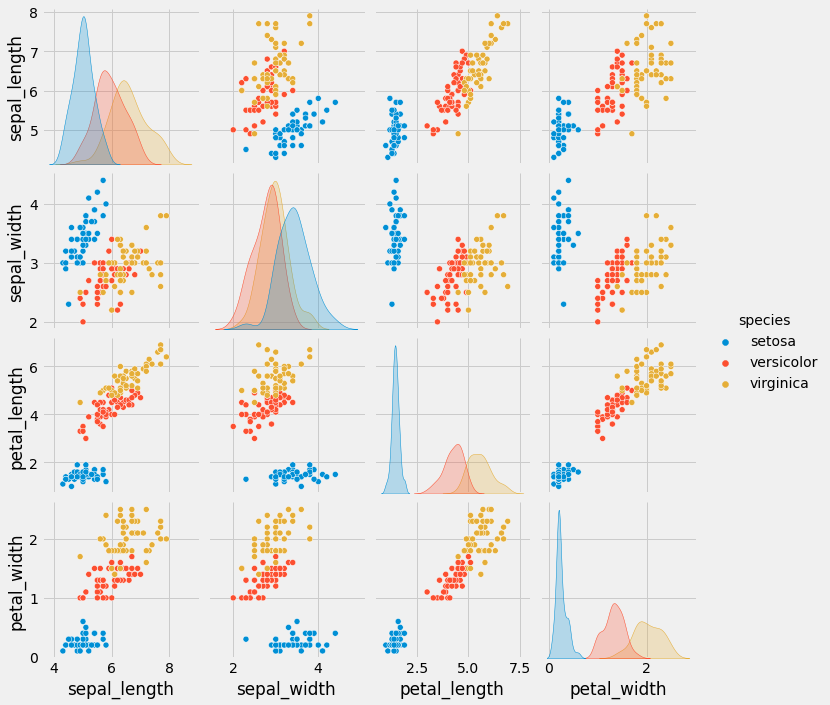

In [114]:
sns.pairplot(iris, hue="species")
# In seaborn, the hue parameter determines which column in the data frame should be used for colour encoding

### Question: 
If we want to choose 2 features from the given 4 features, 
which 2 do you want to choose?

1. Petal_length
2. Petal_width

**Specifying Features and Target Label**

The first 4 columns are the features; whereas the last column "species" is the species label. Our objective is to use the features to predict the species label. So, we can rearrange the data into **features** and **label**.

In [115]:
### Separate "features" and class "species" column from IRIS dataset
iris_features = iris.drop("species", axis=1) 
#A DataFrame object has two axes: “axis 0” and “axis 1”. “axis 0” represents rows and “axis 1” represents columns.
iris_label = iris['species']

In [116]:
iris_features

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [117]:
iris_label

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

### 3. Split Data into Training and Testing Sets
Before we build models from our dataset, it is important to split the data into training and testing sets. The training data will be used to train our model; and subsequently the built model will be evaluated based on the testing sets. 

We can use the "train_test_split" module from the model_selection package to do this automatically for us. However, please note that there are 50 setosa, 50 versicolor and 50 virginica. **It is important that when we split the data, we need to stratify according to the iris species, or else the training and testing data will not be balance in terms of the number of each species**. This is not ideal as it can bias our training/testing with more data on one specific type (i.e. class or category) of species and fewer data on another type of species. In order to ensure a balance split, we use the parameter "stratify" to take into account the species during the split.

Let's assume that we leave out 30% of the datasets for testing, which means that we use 70% of the datasets for training.

In [118]:
### Using package to split data into training and testing sets
from sklearn.model_selection import train_test_split
 
### Split the data into training and testing sets
### test_size = 0.30 (meaning 30% of the data will be used as test set)
### stratify = iris_label (meaning iris_label will be used to stratify the data)
train_features, test_features, train_labels, test_labels = train_test_split(
        iris_features, 
        iris_label, 
        test_size = 0.30, 
        stratify = iris_label, 
        random_state = 1)

In [119]:
train_labels

33         setosa
20         setosa
115     virginica
124     virginica
35         setosa
          ...    
41         setosa
92     versicolor
26         setosa
3          setosa
42         setosa
Name: species, Length: 105, dtype: object

In [120]:
### Checking Training Data and Testing Data dimensions
count_train = np.unique(train_labels, return_counts=True)  # np.unique: numpy, Find the unique elements of an array
count_test = np.unique(test_labels, return_counts=True)

In [121]:
# 70% for training, 50*0.7=35
count_train

(array(['setosa', 'versicolor', 'virginica'], dtype=object),
 array([35, 35, 35], dtype=int64))

In [122]:
# 30% for testing, 50*0.3=15
count_test

(array(['setosa', 'versicolor', 'virginica'], dtype=object),
 array([15, 15, 15], dtype=int64))

In [123]:
print('Training Features Shape:', train_features.shape) #35*3=105 examples
print('Training Labels:', count_train[0], "=", count_train[1])
print('Testing Features Shape:', test_features.shape)  #15*3=45 examples
print('Testing Labels:', count_test[0], "=", count_test[1])

Training Features Shape: (105, 4)
Training Labels: ['setosa' 'versicolor' 'virginica'] = [35 35 35]
Testing Features Shape: (45, 4)
Testing Labels: ['setosa' 'versicolor' 'virginica'] = [15 15 15]


#### Each class has same number of examples in training and testing

### 4. Apply random forest algorithm on the training sets

To build **Random Forest model**, we can import from the sklearn.ensemble package (note that Random Forest is an ensemble tree method). The implementation is very straightforward as shown below.

**Instantiate Random Forest Model**

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control overfitting. 

Please refer to [this page](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for the parameters' settings of RandomForestClassifier.

In [124]:
### Import RandomForestClassifier (Please note that we are doing classification)
from sklearn.ensemble import RandomForestClassifier
 
### Instantiate random forest model using default parameters, 
# but specifying random_state to ensure reproducibility. 
### oob_score=True means that we would like to use oob_score to estimate the training accuracy.
# unused samples (Out of Bag sample) will be used to evaluate the performance of classifier 
# (as they are not used in training anyway)
rf = RandomForestClassifier (n_estimators=10, random_state=1, oob_score=True)

In [125]:
# Note we have built 10 tree, indicated by n_estimators
# typically, we should build a few hundred trees

**Fit a Random Forest Model to the training data**

The parameters used for building the random forest classifier is shown in the output.

In [126]:
# Fit the model on training data
rf.fit(train_features, train_labels)
print(rf.oob_score_)
# Out-of-bag accuracy prediction 

0.9428571428571428


## rf is our random forest model

### 5. Model Evaluation


In [127]:
### Import cross_val_score for cross_validation
from sklearn.model_selection import cross_val_score
 
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
 
print ("OOB_SCORE=", "%.4f" % rf.oob_score_)  # keep 4 decimal placce

cv_score = cross_val_score(rf, train_features, train_labels, cv=10)
print(cv_score)
print ("Ten-fold Cross Validation Score=", "%.4f" % np.mean(cv_score)) 
#average of 10 iterations

OOB_SCORE= 0.9429
[1.00 1.00 1.00 0.91 0.91 1.00 0.90 0.90 0.90 0.90]
Ten-fold Cross Validation Score= 0.9418


It seems the results are similar.

**Testing Performance**

The model performance on the training data is approximately 94%. We would like to check how the model performs when apply on new data (test data) which is not part of the training data. We can simply use the function "score" to get the test performance.

Note that we have left out 30% of the dataset for testing. They are "test_features" with species label as "test_labels".

In [128]:
### Get the prediction score
test_score = rf.score(test_features, test_labels) 
# including to use rf to predict test data test_features and 
# comparison with ground truth test_labels

print ("Testing Performance:", "%.4f" % test_score)

Testing Performance: 0.9778


It seems the results are better in seperate test set

In [129]:
### Get the predicted labels
prediction = rf.predict(test_features)

#We want to get how many examples in each class in test data
count_prediction = np.unique(prediction, return_counts=True)
print('Predicted Labels:', count_prediction[0], "=", count_prediction[1])

Predicted Labels: ['setosa' 'versicolor' 'virginica'] = [15 16 14]


**Confusion Matrix**

We have obtained the predicted labels in the previous section. However, we would like to have the confusion matrix which tells us how many of the specific species have been classified correctly, i.e. True vs Predicted label.

[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]


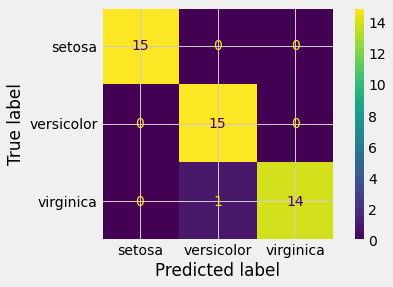

In [130]:
### Import confusion_matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
 
### Create confusion matrix
conf_matrix = confusion_matrix (test_labels, prediction)
print (conf_matrix)
 
### Plot confusion matrix
disp = plot_confusion_matrix(rf, test_features, test_labels, display_labels = ['setosa' ,'versicolor' ,'virginica'] )

**Classification Report**

Classification Report will give the precision and recall of the model on the test data for each species. In particular, TP = True Positive; FP = False Positive; TN = True Negative; and FN = False Negative.

Precision  = TP / (TP + FP); 

Recall = TP / (TP + FN)

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)


In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

Macro-average: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. In other words, it treats all classes equally, irregardless of their size. 


Weighted-average: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [131]:
### Import classification_report
from sklearn.metrics import classification_report
print(classification_report(test_labels, prediction, target_names=['setosa' ,'versicolor' ,'virginica']))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



### Note the versicolor's precision is 0.94, while the virginica's recall is 0.93, why?

In [132]:
format_float = "{:.2f}".format(15/16)
print(format_float)

0.94


In [133]:
format_float = "{:.2f}".format(14/15)
print(format_float)

0.93


### 6. Feature Importance

Feature importance measures the relative importance of the feature in the model. The higher the value, the more important it is. Feature importance is normalized to 0 - 1. The sum all all features' importance will be equal to 1. 

**Get the numerical feature importances**

In [134]:
iris_features.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [135]:
### Get numerical feature importances
importances = list(rf.feature_importances_)
importances

[0.26181878540936293,
 0.027472086569354605,
 0.3734448303180564,
 0.337264297703226]

In [136]:
features_list = iris_features.columns
features_list

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

In [137]:
### List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
 
### Sort the feature importances by most important first 
#(i.e. larger value means more important)
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
 
### Print out the feature and importances 
[print('Variable RF: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable RF: petal_length         Importance: 0.37
Variable RF: petal_width          Importance: 0.34
Variable RF: sepal_length         Importance: 0.26
Variable RF: sepal_width          Importance: 0.03


**Plot Feature Importance Barchart**

In [138]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
 
### Set the style
plt.style.use('fivethirtyeight') # try to replicate the styles from FiveThirtyEight.com.

In [139]:
### list of x locations for plotting
x_values = list(range(len(importances)))
x_values

[0, 1, 2, 3]

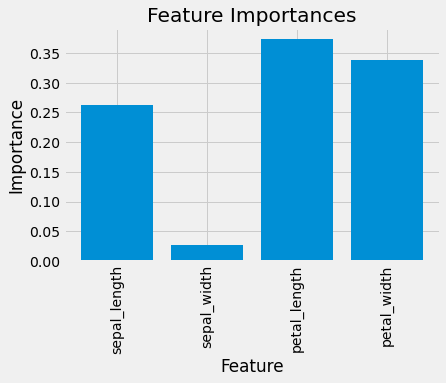

In [140]:
### Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
### Tick labels for x axis
plt.xticks(x_values, features_list, rotation='vertical')
### Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances');

### 7. Add noise to the data

### let's say 100 noise variables

In [141]:
random_state = np.random.RandomState(1)
 
### Get number of samples
n_samples = iris_features.shape[0]
n_samples

150

In [142]:
### Create 100 random features as dummy_var
dummy_var = []
for i in range(1,101):
  dummy_var.append("col" + str(i))
dummy_var # 100 dummy variable names

['col1',
 'col2',
 'col3',
 'col4',
 'col5',
 'col6',
 'col7',
 'col8',
 'col9',
 'col10',
 'col11',
 'col12',
 'col13',
 'col14',
 'col15',
 'col16',
 'col17',
 'col18',
 'col19',
 'col20',
 'col21',
 'col22',
 'col23',
 'col24',
 'col25',
 'col26',
 'col27',
 'col28',
 'col29',
 'col30',
 'col31',
 'col32',
 'col33',
 'col34',
 'col35',
 'col36',
 'col37',
 'col38',
 'col39',
 'col40',
 'col41',
 'col42',
 'col43',
 'col44',
 'col45',
 'col46',
 'col47',
 'col48',
 'col49',
 'col50',
 'col51',
 'col52',
 'col53',
 'col54',
 'col55',
 'col56',
 'col57',
 'col58',
 'col59',
 'col60',
 'col61',
 'col62',
 'col63',
 'col64',
 'col65',
 'col66',
 'col67',
 'col68',
 'col69',
 'col70',
 'col71',
 'col72',
 'col73',
 'col74',
 'col75',
 'col76',
 'col77',
 'col78',
 'col79',
 'col80',
 'col81',
 'col82',
 'col83',
 'col84',
 'col85',
 'col86',
 'col87',
 'col88',
 'col89',
 'col90',
 'col91',
 'col92',
 'col93',
 'col94',
 'col95',
 'col96',
 'col97',
 'col98',
 'col99',
 'col100']

In [143]:
n_samples

150

In [144]:
random_features = pd.DataFrame (columns=dummy_var, data = random_state.rand(n_samples,100)) 
#pandas to generate a dataframe with 150 rows and 100 columns, with column name dummy_var
random_features

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col91,col92,col93,col94,col95,col96,col97,col98,col99,col100
0,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339,0.186260,0.345561,0.396767,0.538817,...,0.114746,0.949489,0.449912,0.578390,0.408137,0.237027,0.903380,0.573679,0.002870,0.617145
1,0.326645,0.527058,0.885942,0.357270,0.908535,0.623360,0.015821,0.929437,0.690897,0.997323,...,0.263297,0.065961,0.735066,0.772178,0.907816,0.931972,0.013952,0.234362,0.616778,0.949016
2,0.950176,0.556653,0.915606,0.641566,0.390008,0.485991,0.604310,0.549548,0.926181,0.918733,...,0.519012,0.770884,0.568858,0.465710,0.342689,0.068209,0.377924,0.079626,0.982817,0.181613
3,0.811859,0.874962,0.688413,0.569494,0.160971,0.466880,0.345172,0.225040,0.592512,0.312270,...,0.211960,0.798604,0.297331,0.027606,0.593432,0.843840,0.381016,0.749858,0.511141,0.540952
4,0.959434,0.803961,0.032323,0.709387,0.465001,0.947549,0.221433,0.267072,0.081474,0.428619,...,0.517268,0.916406,0.426475,0.247396,0.371294,0.931861,0.936868,0.844330,0.920207,0.227900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.897718,0.683464,0.132218,0.513373,0.221816,0.623087,0.493887,0.539220,0.389829,0.609327,...,0.400882,0.819394,0.894981,0.377109,0.291892,0.952854,0.801276,0.157560,0.895345,0.920552
146,0.195471,0.803184,0.776741,0.562639,0.537713,0.377197,0.924070,0.173090,0.251744,0.224947,...,0.793869,0.521480,0.938039,0.619780,0.119892,0.008163,0.378685,0.817485,0.270454,0.164525
147,0.648314,0.235101,0.301396,0.030675,0.735227,0.357290,0.587683,0.805721,0.761062,0.051229,...,0.676536,0.969938,0.095070,0.438297,0.663252,0.324007,0.419873,0.143869,0.998556,0.176509
148,0.452466,0.343985,0.855881,0.518123,0.985959,0.938037,0.405160,0.599493,0.000892,0.171369,...,0.587533,0.974004,0.125810,0.638994,0.552450,0.099204,0.444491,0.513824,0.016505,0.940351


In [145]:
### add dummy_var to iris_features so that we get new data/features new_iris_features
new_iris_features = iris_features
new_iris_features[dummy_var] = random_features # add features
# Add new noise features/data to IRIS data
print ("IRIS new dimension:", new_iris_features.shape)
print(new_iris_features)

IRIS new dimension: (150, 104)
     sepal_length  sepal_width  petal_length  petal_width      col1      col2  \
0             5.1          3.5           1.4          0.2  0.417022  0.720324   
1             4.9          3.0           1.4          0.2  0.326645  0.527058   
2             4.7          3.2           1.3          0.2  0.950176  0.556653   
3             4.6          3.1           1.5          0.2  0.811859  0.874962   
4             5.0          3.6           1.4          0.2  0.959434  0.803961   
..            ...          ...           ...          ...       ...       ...   
145           6.7          3.0           5.2          2.3  0.897718  0.683464   
146           6.3          2.5           5.0          1.9  0.195471  0.803184   
147           6.5          3.0           5.2          2.0  0.648314  0.235101   
148           6.2          3.4           5.4          2.3  0.452466  0.343985   
149           5.9          3.0           5.1          1.8  0.225287  0.037053 

We have 104 features now

**Create new training and testing data**

In [146]:
new_train_features, new_test_features, new_train_labels, new_test_labels = train_test_split(
        new_iris_features, 
        iris_label, 
        test_size = 0.30, 
        stratify = iris_label, 
        random_state = 1)

**Fit Random Forest Classifier**

In [147]:
#Traing new model new_rf
new_rf = RandomForestClassifier (n_estimators=10, random_state=1, oob_score=True)
new_rf.fit(new_train_features, new_train_labels) # fit data and lables

RandomForestClassifier(n_estimators=10, oob_score=True, random_state=1)

## Our new RF model is called new_rf

**Model Evaluation**

In [148]:
#Evaluate 1: OOB and accuracy
print ("OOB_SCORE=", "%.4f" % new_rf.oob_score_)
new_cv_score = cross_val_score(new_rf, new_train_features, new_train_labels, cv=10)
print ("Ten-fold Cross Validation Score=", "%.4f" % np.mean(new_cv_score))

OOB_SCORE= 0.6762
Ten-fold Cross Validation Score= 0.8955


In [149]:
? cross_val_score

In [150]:
#Evaluate 2:Testing Performance in terms of accuracy
new_test_score = new_rf.score(new_test_features, new_test_labels)
print ("Testing Performance:", "%.4f" % new_test_score)

Testing Performance: 0.8889


In [151]:
### Get the predicted labels
new_prediction = new_rf.predict(new_test_features)
new_prediction

array(['virginica', 'setosa', 'setosa', 'setosa', 'versicolor',
       'versicolor', 'virginica', 'versicolor', 'virginica', 'setosa',
       'setosa', 'virginica', 'setosa', 'versicolor', 'setosa',
       'versicolor', 'virginica', 'versicolor', 'versicolor', 'virginica',
       'virginica', 'setosa', 'versicolor', 'virginica', 'versicolor',
       'versicolor', 'setosa', 'virginica', 'setosa', 'virginica',
       'setosa', 'setosa', 'versicolor', 'setosa', 'virginica',
       'virginica', 'setosa', 'setosa', 'setosa', 'versicolor',
       'virginica', 'setosa', 'virginica', 'setosa', 'setosa'],
      dtype=object)

In [152]:
new_test_labels

148     virginica
5          setosa
6          setosa
106     virginica
75     versicolor
71     versicolor
108     virginica
68     versicolor
111     virginica
16         setosa
15         setosa
127     virginica
8          setosa
57     versicolor
47         setosa
76     versicolor
141     virginica
66     versicolor
74     versicolor
147     virginica
102     virginica
12         setosa
65     versicolor
121     virginica
94     versicolor
56     versicolor
98     versicolor
144     virginica
43         setosa
113     virginica
11         setosa
0          setosa
62     versicolor
53     versicolor
107     virginica
112     virginica
37         setosa
25         setosa
1          setosa
50     versicolor
120     virginica
149     virginica
54     versicolor
7          setosa
9          setosa
Name: species, dtype: object

In [153]:
new_count_prediction = np.unique(new_prediction, return_counts=True)
print('Predicted Labels:', new_count_prediction[0], "=", new_count_prediction[1])

Predicted Labels: ['setosa' 'versicolor' 'virginica'] = [19 12 14]


[[15  0  0]
 [ 2 12  1]
 [ 2  0 13]]


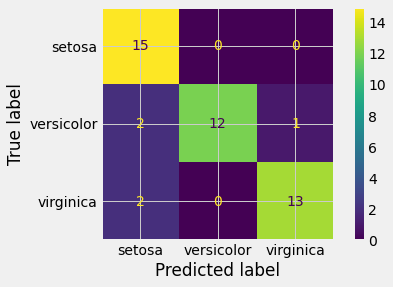

In [154]:
#Evaluate 3:Testing Performance using confusing matrix
new_conf_matrix = confusion_matrix (new_test_labels, new_prediction)
print (new_conf_matrix)
 
### Plot confusion matrix
new_disp = plot_confusion_matrix(new_rf, new_test_features, new_test_labels, display_labels = ['setosa' ,'versicolor' ,'virginica'] )

In [155]:
#Evaluate 4:Testing Performance using confusing matrix
print(classification_report(new_test_labels, new_prediction, target_names=['setosa' ,'versicolor' ,'virginica']))

              precision    recall  f1-score   support

      setosa       0.79      1.00      0.88        15
  versicolor       1.00      0.80      0.89        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.89        45
   macro avg       0.91      0.89      0.89        45
weighted avg       0.91      0.89      0.89        45



### Classification report and confusing matrix on test set provide very clear picture

**Feature Importance**

In [156]:
### Get the features list (i.e. column feature name)
new_features_list = new_iris_features.columns
new_features_list

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'col1',
       'col2', 'col3', 'col4', 'col5', 'col6',
       ...
       'col91', 'col92', 'col93', 'col94', 'col95', 'col96', 'col97', 'col98',
       'col99', 'col100'],
      dtype='object', length=104)

In [157]:
### Get numerical feature importances
new_importances = list(new_rf.feature_importances_)

In [158]:
### List of tuples with variable and importance
new_feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(new_features_list, new_importances)]
 
### Sort the feature importances by most important first (i.e. larger value means more important)
new_feature_importances = sorted(new_feature_importances, key = lambda x: x[1], reverse = True)
 
[print('Variable RF: {:20} Importance: {}'.format(*pair)) for pair in new_feature_importances];

Variable RF: petal_length         Importance: 0.17
Variable RF: sepal_length         Importance: 0.12
Variable RF: petal_width          Importance: 0.12
Variable RF: col50                Importance: 0.03
Variable RF: col24                Importance: 0.02
Variable RF: col40                Importance: 0.02
Variable RF: col43                Importance: 0.02
Variable RF: col44                Importance: 0.02
Variable RF: col52                Importance: 0.02
Variable RF: col59                Importance: 0.02
Variable RF: col66                Importance: 0.02
Variable RF: col84                Importance: 0.02
Variable RF: col97                Importance: 0.02
Variable RF: sepal_width          Importance: 0.01
Variable RF: col1                 Importance: 0.01
Variable RF: col7                 Importance: 0.01
Variable RF: col9                 Importance: 0.01
Variable RF: col10                Importance: 0.01
Variable RF: col11                Importance: 0.01
Variable RF: col12             

**Evaluate Number of Estimators, i.e. Number of Trees**

Text(0, 0.5, 'Testing Accuracy')

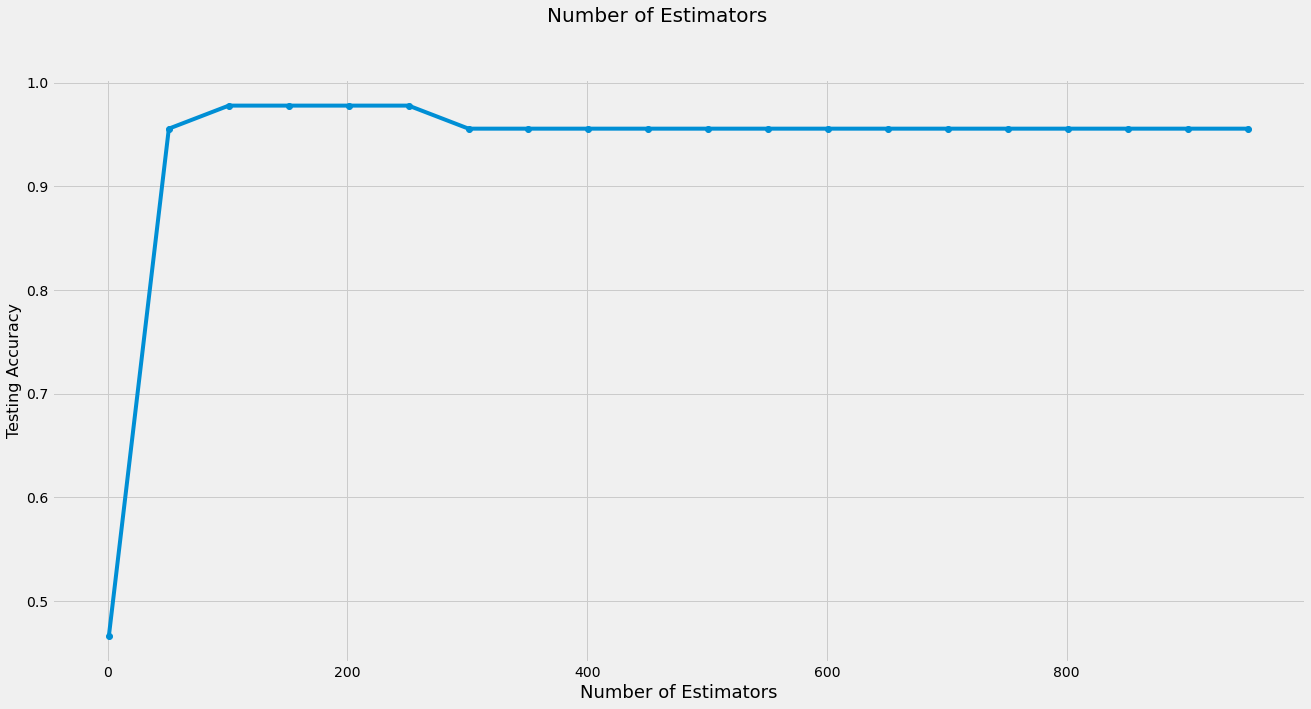

In [163]:
import matplotlib.pyplot as plt

score_array =[]
num_estimators = []
for k in range(1,1001,50):
    clf = RandomForestClassifier(n_estimators=k, random_state=1, max_depth=3) #The maximum depth of the tree.
    clf = clf.fit(new_train_features, new_train_labels)

    #Predict the response for test dataset
    score_array.append(clf.score(new_test_features, new_test_labels))
    num_estimators.append(k)
    
fig = plt.figure(figsize=(20, 10))
plt.plot(num_estimators, score_array, marker='o')
fig.suptitle('Number of Estimators', fontsize=20)
plt.xlabel('Number of Estimators', fontsize=18)
plt.ylabel('Testing Accuracy', fontsize=16)

### This provides a way to tune the parameter, i.e., number of trees.

In [164]:
? plt.figure